In [1]:
! pip install opendatasets

# Load datasets from Kaggle

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mazenatefmohamed
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k


In [3]:
import os
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict

captions_path = '/content/flickr8k/captions.txt'
images_dir = '/content/flickr8k/Images'

# Read the captions file
with open(captions_path, 'r') as f:
    captions = f.readlines()

# Remove the header line
captions = captions[1:]

#  Build Map for every image
## image ==> {caption 1, caption 2, caption 3, caption 4, caption 5}

In [4]:
# Build a dictionary {image_name: [list of 5 captions]}

def build_image_caption_map(captions):
    image_caption_map = defaultdict(list)
    for line in captions:
        image_name, caption = line.strip().split(',', 1)
        # Add the caption to the corresponding image name
        image_caption_map[image_name].append(caption)
    print("number of image: ",len(image_caption_map))
    return image_caption_map

In [5]:
# Build the image-caption map
image_caption_map = build_image_caption_map(captions)

number of image:  8091


In [6]:
from collections import Counter
import matplotlib.pyplot as plt

def visualize_caption_stats(image_caption_map):
    all_captions = []

    for captions in image_caption_map.values():
        all_captions.extend(captions)

    all_words = []
    for caption in all_captions:
        all_words.extend(caption.lower().split())  # lowercase to avoid case-based duplicates

    word_counts = Counter(all_words)

    # Count repeated words
    count_1 = sum(1 for count in word_counts.values() if count == 1)
    count_2 = sum(1 for count in word_counts.values() if count == 2)
    count_3 = sum(1 for count in word_counts.values() if count == 3)
    count_4_or_more = sum(1 for count in word_counts.values() if count >= 4)

    # Stats summary
    num_images = len(image_caption_map)
    num_captions = len(all_captions)
    total_words = len(all_words)
    unique_words = len(word_counts)

    print("📷 Number of images:", num_images)
    print("📝 Number of captions:", num_captions)
    print("🔤 Total number of words:", total_words)
    print("🆕 Number of unique words:", unique_words)
    print("🔁 Words repeated exactly 1 time:", count_1)
    print("🔁 Words repeated exactly 2 times:", count_2)
    print("🔁 Words repeated exactly 3 times:", count_3)
    print("🔁 Words repeated 4 or more times:", count_4_or_more)

    # Visualization
    labels = ['unique_words','Exactly 1', 'Exactly 2', 'Exactly 3', '4 or more']
    values = [unique_words,count_1, count_2, count_3, count_4_or_more]

    plt.figure(figsize=(8,5))
    plt.bar(labels, values, color=['blue','lightcoral', 'skyblue', 'orange', 'lightgreen'])
    plt.title("Word Repetition Frequency")
    plt.ylabel("Number of Words")
    plt.xlabel("Repetition Category")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


📷 Number of images: 8091
📝 Number of captions: 40455
🔤 Total number of words: 476665
🆕 Number of unique words: 9180
🔁 Words repeated exactly 1 time: 3864
🔁 Words repeated exactly 2 times: 1160
🔁 Words repeated exactly 3 times: 677
🔁 Words repeated 4 or more times: 3479


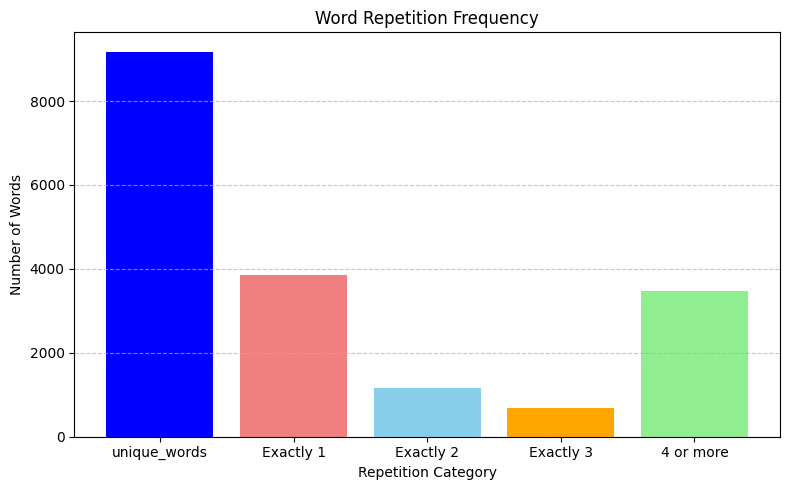

In [7]:
visualize_caption_stats(image_caption_map)


# Preprocessing for caption map


In [8]:
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

In [9]:
import nltk
nltk.download('stopwords') # to stopwords
nltk.download('wordnet')  # to lemmatization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [10]:
def preprocess_captions(captions_map, add_tokens=False, do_stemming=False, do_lemmatization=False):

    table = str.maketrans('', '', string.punctuation)

    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    cleaned_map = {}

    for image_id, desc_list in captions_map.items():
        cleaned_map[image_id] = []
        for desc in desc_list:

            # Lowercase
            desc = desc.lower()

            # Remove punctuation
            desc = desc.translate(table)

            # Tokenize
            words = desc.split()

            # Clean words: remove non-alphabetic, short words
            words = [word for word in words if word.isalpha() and len(word) > 1]

            # Optional: Lemmatization
            if do_lemmatization:
                words = [lemmatizer.lemmatize(word) for word in words]

            # Optional: Stemming
            if do_stemming:
                words = [stemmer.stem(word) for word in words]

            # Optional: Remove stopwords (Uncomment if you want it)
            words = [word for word in words if word not in stop_words]

            # Reconstruct the cleaned caption
            desc = ' '.join(words)

            # Optional: Add startseq and endseq tokens
            if add_tokens:
                desc = 'startseq ' + desc + ' endseq'

            cleaned_map[image_id].append(desc)

    return cleaned_map


In [11]:
# preprocessing
cleaned_image_caption_map = preprocess_captions(
    captions_map=image_caption_map,
    add_tokens=True,
    do_stemming=False,
    do_lemmatization=True
)


# visualization

In [12]:
# Display the image and its 5 captions based on the index

def show_image_and_captions_by_index(image_caption_map, index):
    image_names = list(image_caption_map.keys())
    if index >= len(image_names):
        print("Index is out of range.")
        return

    image_name = image_names[index]
    captions = image_caption_map[image_name]

    # Load the image
    image_path = os.path.join(images_dir, image_name)
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image {image_name} not found!")
        return

    # Convert BGR image to RGB for correct display
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(7, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image: {image_name}', fontsize=12)
    plt.show()

    # Print the 5 captions for this image
    print("Captions:")
    for i, cap in enumerate(captions):
        print(f"{i+1}. {cap}")


***Display the image with 5 caption***


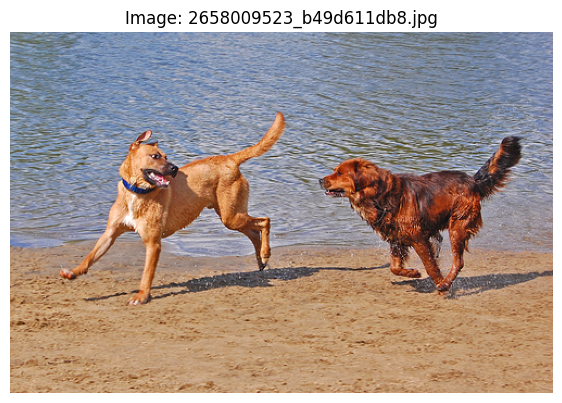

Captions:
1. A brown dog and a red dog frolicking on the waters edge on the beach .
2. two brown dogs are running on the beach beside the ocean .
3. Two brown dogs chase and playfully fight with each other on the sandy beach .
4. Two brown dogs play on the sand by the water .
5. Two dogs running down a beach .

***Display the image with 5 caption***


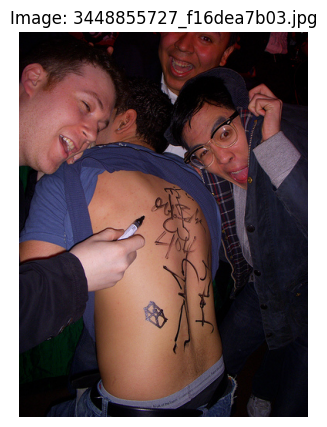

Captions:
1. A group of kids are writing with a black marker on one of their friend 's back .
2. A group of young men laugh as they write on a friend 's back with a marker .
3. Boys at a party drawing on their friend 's back with a black marker .
4. Fellows writing on the back of a friend with black markers .
5. People are writing and drawing on the back of another person with a marker .


In [13]:
# Display the first image and its 5 captions
print("***Display the image with 5 caption***")
show_image_and_captions_by_index(image_caption_map, 2566)

print("\n***Display the image with 5 caption***")

show_image_and_captions_by_index(image_caption_map, 5698)


***Captions before preprocessing***


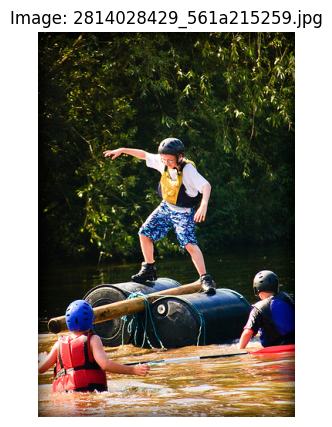

Captions:
1. A boy balances on something inflatable
2. A boy tries to keep his balance while standing on two floating devices while two others watch .
3. A kid wearing safety gear stands on some material in the water .
4. Little kids play in the water while their friend poses on top of their raft .
5. There are two children in the water and one balancing on a float and they are all wearing helmets .

***Captions after preprocessing***


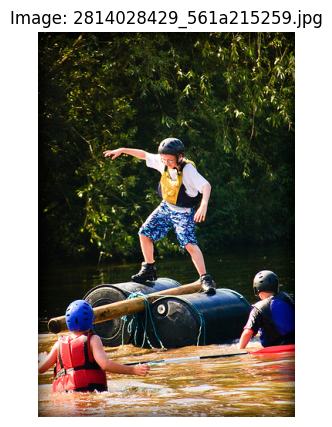

Captions:
1. startseq boy balance something inflatable endseq
2. startseq boy try keep balance standing two floating device two others watch endseq
3. startseq kid wearing safety gear stand material water endseq
4. startseq little kid play water friend pose top raft endseq
5. startseq two child water one balancing float wearing helmet endseq


In [14]:
# Display the image before cleated the captions
print("***Captions before preprocessing***")
show_image_and_captions_by_index(image_caption_map, 2999)

# Display the image after cleated the captions
print("\n***Captions after preprocessing***")
show_image_and_captions_by_index(cleaned_image_caption_map, 2999)


## What is a WordCloud?

### A **WordCloud** is a visual representation of the most frequent words in agiven text or collection of texts. It helps to quickly understand the key themes or topics based on word frequency.

In [15]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def generate_wordcloud(captions_map,tittle):
    # Combine all captions into one large text
    all_captions = " ".join([" ".join(desc_list) for desc_list in captions_map.values()])
    # all_captions = " ".join(set(" ".join([" ".join(desc_list) for desc_list in captions_map.values()]).split()))


    # Generate the word cloud
    wordcloud = WordCloud(
        width=1000,
        height=400,
        background_color="black",
        stopwords=STOPWORDS,  # Use default stopwords from WordCloud
        colormap="twilight_shifted_r"  # You can change the color map if you want
    ).generate(all_captions)

    # Plot the Word Cloud
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Hide axes
    plt.title(tittle, fontsize=20)
    plt.show()

    # Save the wordcloud image
    # wordcloud.to_file('/content/wordcloud.png')



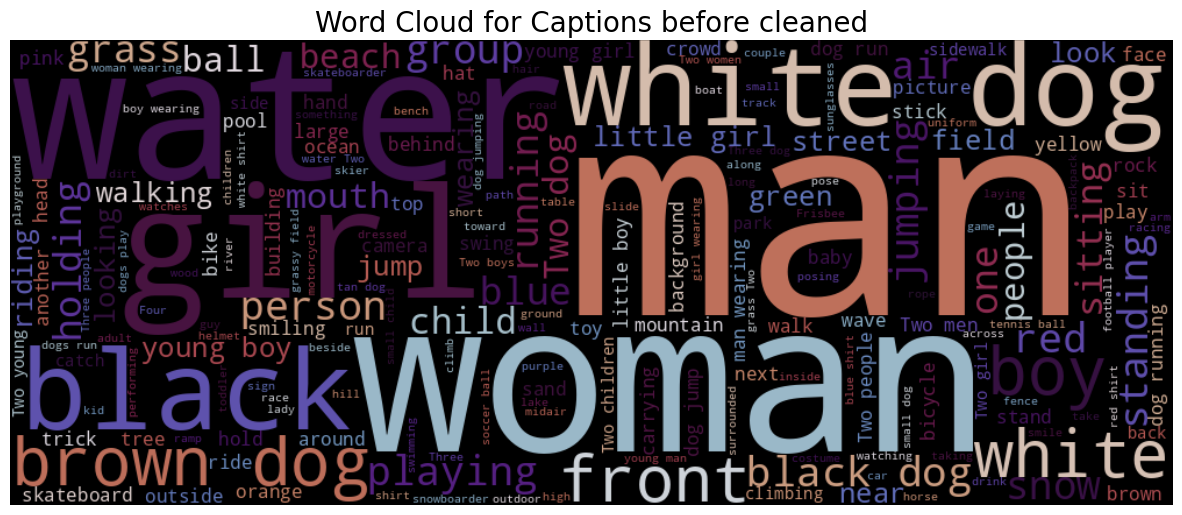

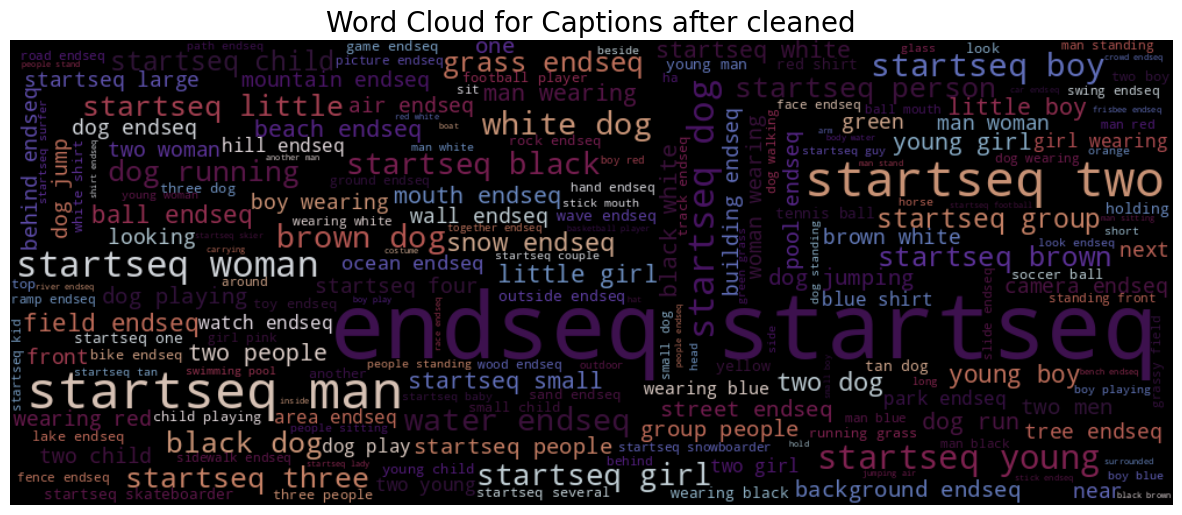

In [16]:
# Call the function and pass your cleaned map
generate_wordcloud(image_caption_map,"Word Cloud for Captions before cleaned")

generate_wordcloud(cleaned_image_caption_map,"Word Cloud for Captions after cleaned")


## 📊 Top N Frequent Words Bar Chart

### The `plot_top_words_from_map` function is used to visualize the **most frequent words** in a set of image captions by plotting a **bar chart**.

In [17]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_top_words_from_map(captions_map, top_n=20, tittle=""):
    # Collect all words from the captions map
    all_words = []
    for desc_list in captions_map.values():
        for caption in desc_list:
            all_words.extend(caption.split())

    # Count the frequency of each word
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(top_n)
    words, counts = zip(*common_words)

    # Plot the bar chart for the most frequent words
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts, color='blue')
    plt.xticks(rotation=45)
    plt.title(tittle)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.show()


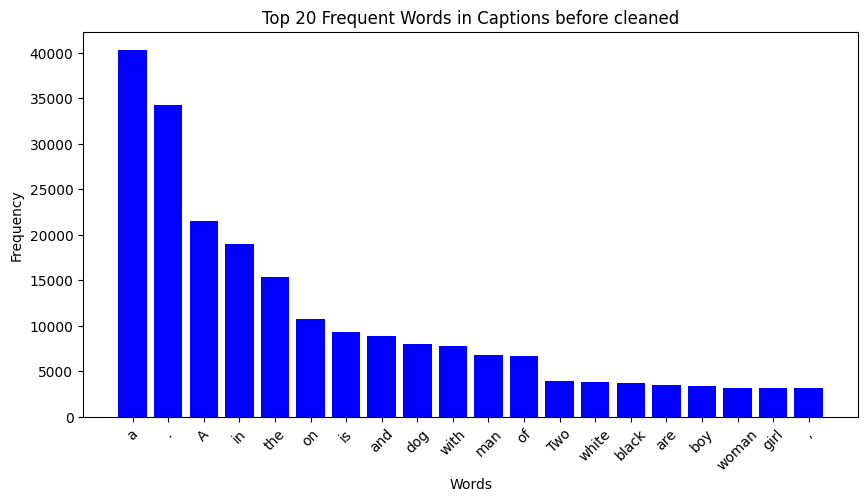

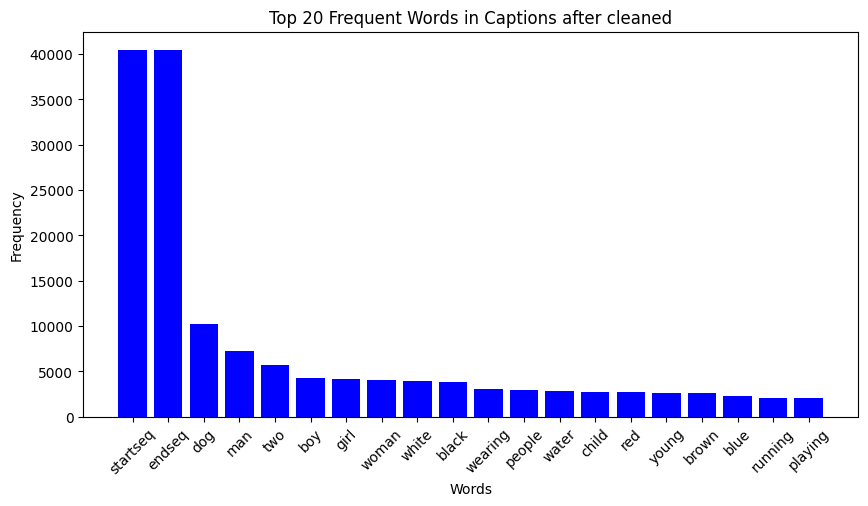

In [18]:
plot_top_words_from_map(image_caption_map,20,"Top 20 Frequent Words in Captions before cleaned")
plot_top_words_from_map(cleaned_image_caption_map,20,"Top 20 Frequent Words in Captions after cleaned")


## Caption Length Distribution
###The `plot_caption_length_distribution_from_map` function is used to visualize the **distribution of caption lengths** by plotting a **histogram**.

In [19]:
def plot_caption_length_distribution_from_map(captions_map,tittle):
    # Calculate the number of words in each caption
    caption_lengths = []
    for desc_list in captions_map.values():
        for caption in desc_list:
            caption_lengths.append(len(caption.split()))

    # Plot the histogram of caption lengths
    plt.figure(figsize=(8,4 ))
    plt.hist(caption_lengths, bins=20, color='blue',edgecolor='black')
    plt.title(tittle)
    plt.xlabel("Number of Words per Caption")
    plt.ylabel("Number of Captions")
    plt.show()


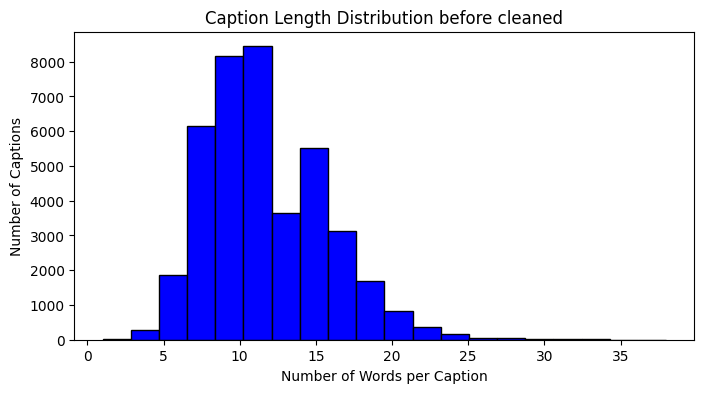

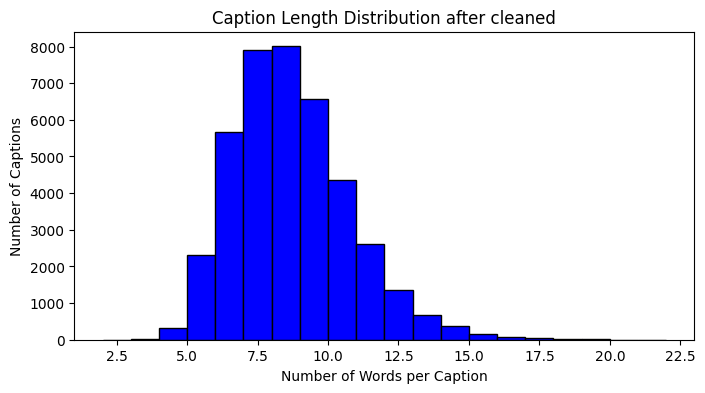

In [20]:
plot_caption_length_distribution_from_map(image_caption_map,"Caption Length Distribution before cleaned")

plot_caption_length_distribution_from_map(cleaned_image_caption_map,"Caption Length Distribution after cleaned")


## Unique vs Repeated Vocabulary Analysis

### The `plot_vocab_unique_vs_repeated_from_map` function helps visualize the **distribution of unique and repeated words** in the caption dataset using a **pie chart**.

In [21]:
def plot_vocab_unique_vs_repeated_from_map(captions_map,tittle):
    # Collect all words from the captions map
    all_words = []
    for desc_list in captions_map.values():
        for caption in desc_list:
            all_words.extend(caption.split())

    # Count the frequency of each word
    word_freq = Counter(all_words)
    unique = sum(1 for word in word_freq if word_freq[word] == 1)
    repeated = len(word_freq) - unique

    # Plot the pie chart for unique vs repeated words
    plt.figure(figsize=(5, 5))
    plt.pie(
        [unique, repeated],
        labels=['Unique Words', 'Repeated Words'],
        autopct='%1.1f%%',
        colors=['blue', 'Lavender', 'mediumpurple', 'gold']
    )
    plt.title(tittle)
    plt.show()


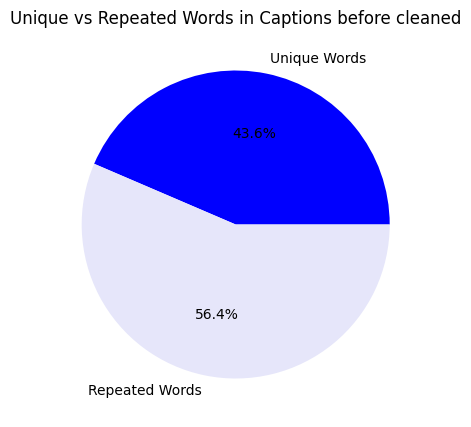

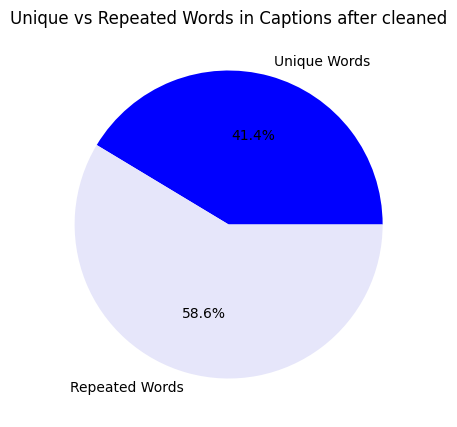

In [22]:
plot_vocab_unique_vs_repeated_from_map(image_caption_map,"Unique vs Repeated Words in Captions before cleaned")
plot_vocab_unique_vs_repeated_from_map(cleaned_image_caption_map,"Unique vs Repeated Words in Captions after cleaned")


## 📊 Top Repeated Captions Across Different Images

### This bar chart visualizes the most frequently repeated captions that appear across **multiple distinct images**. It helps in understanding caption redundancy and detecting commonly reused phrases across the dataset.

In [23]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_repeated_captions_across_images(image_caption_map, top_n=10,text=""):
    # Step 1: Build caption to images map
    caption_to_images = defaultdict(set)
    for image, captions in image_caption_map.items():
        for caption in captions:
            caption_to_images[caption].add(image)

    # Step 2: Filter repeated captions (appeared in > 1 image)
    repeated_captions = {caption: imgs for caption, imgs in caption_to_images.items() if len(imgs) > 1}

    # Step 3: Sort by number of images
    sorted_repeats = sorted(repeated_captions.items(), key=lambda x: len(x[1]), reverse=True)[:top_n]
    captions = [caption for caption, imgs in sorted_repeats]
    counts = [len(imgs) for caption, imgs in sorted_repeats]

    # Step 4: Plot
    plt.figure(figsize=(8, 4))
    plt.barh(range(len(captions)), counts, color="blue")
    plt.yticks(range(len(captions)), captions)
    plt.xlabel("Number of Different Images")
    plt.title(f"Top Repeated Captions Across Different Images {text}")
    plt.gca().invert_yaxis()  # to show most repeated at top
    plt.tight_layout()
    plt.show()


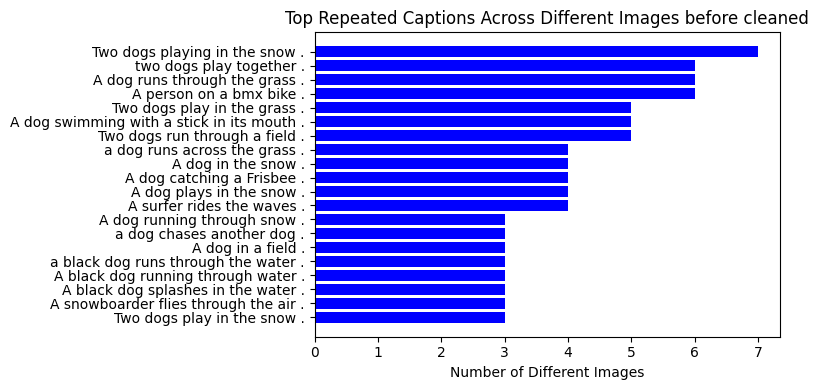

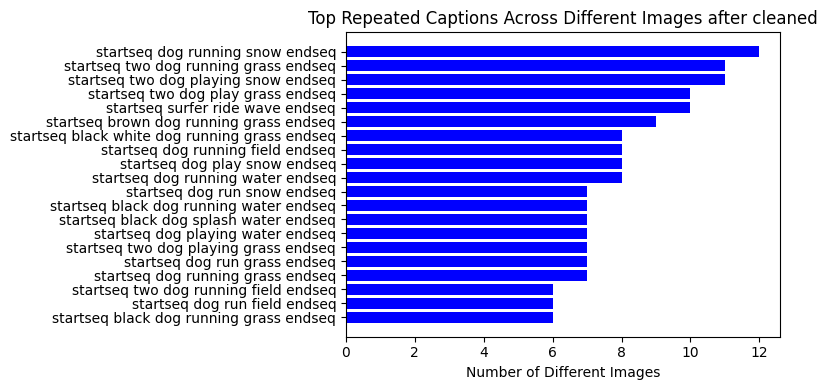

In [24]:
plot_repeated_captions_across_images(image_caption_map, top_n=20,text= "before cleaned")
plot_repeated_captions_across_images(cleaned_image_caption_map, top_n=20,text= "after cleaned")